# Связанные тетрадки
- [EDA](https://www.kaggle.com/maximmezhov/cardiospike-eda)
- [model_v3](https://www.kaggle.com/maximmezhov/cardiospike-baseline-tuning)

# Гипотеза
Подготовленный следующим образом датасет даст лучшее значение метрики на модели v3:  
- добавление в качестве признаков четвёртые точки до и после текущей, т.е x-4 и х+4, 
- а также отклонение для этих точект относительно х: х-(х-4), х-(х+4),
- удаление точек выше 1000мс и ниже 400мс

Лучшее на текущий момент значение метрики 0.9318277932842765

In [1]:
import pandas as pd
import pickle
import lightgbm as lgb

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import f1_score

In [2]:
# Const
RANDOM_STATE = 0

In [3]:
def make_XY(df):
    """
    df: dataset
    return:
    X: numpy array with features, values are scaled
    y: numpy array of target labels
    """
    X = df.drop(['y','id','time'], axis=1)
    y = df.y.to_numpy()

    scaler = StandardScaler().fit(X.to_numpy())
    X = scaler.transform(X.to_numpy())

    with open('scaler_hypothesis_2.pkl', 'wb') as f:
        pickle.dump(scaler, f)
        
    print('scaler_hypothesis_2.pkl was saved in output directory')

    return X, y


def get_train_test_indexes(X,y):
    """
    X,y: numpy arrays with features and target
    return stratified indexes:
        train_indexes: indexes for train data
        test_indexes: indexes for test data
    """
    skf = StratifiedKFold()
    folds = dict()
    for i, (train_indexes, test_indexes) in enumerate(skf.split(X,y)):
        folds[i] = {
            'train_indexes': train_indexes,
            'test_indexes': test_indexes
        }
    return folds[0]['train_indexes'].tolist(), folds[0]['test_indexes'].tolist()

# Подготовка датасета

In [4]:
df = pd.read_csv('../input/cardiospikecompetition/train.csv')
ids = df.id.unique()
for rr_id in ids:
    mask = (df.id==rr_id)
    df.loc[mask, 'x_diff'] = df[mask].x.diff()
    df.loc[mask, 'x_deviation_median'] = df[mask].x.median() - df[mask].x.values
    for i in range(1,5):
        # добавим в признаки 4 следующие точки
        df.loc[mask, f'x+{i}'] = df[mask].x.shift(-i)
        # и 4 предыдущие точки
        df.loc[mask, f'x-{i}'] = df[mask].x.shift(i)
    df.loc[mask, 'x-(x+1)'] = df[mask].x.values - df.loc[mask, 'x+1'].values
#     df.loc[mask, 'x-(x-1)'] = df[mask].x.values - df.loc[mask, 'x-1'].values
    df.loc[mask, 'x-(x+2)'] = df[mask].x.values - df.loc[mask, 'x+2'].values
    df.loc[mask, 'x-(x-2)'] = df[mask].x.values - df.loc[mask, 'x-2'].values
    df.loc[mask, 'x-(x+3)'] = df[mask].x.values - df.loc[mask, 'x+3'].values
    df.loc[mask, 'x-(x-3)'] = df[mask].x.values - df.loc[mask, 'x-3'].values
    df.loc[mask, 'x-(x+4)'] = df[mask].x.values - df.loc[mask, 'x+4'].values
    df.loc[mask, 'x-(x-4)'] = df[mask].x.values - df.loc[mask, 'x-4'].values

In [5]:
print('TEST')
print('- всего ритмограмм в наборе данных', len(df.id.unique()), 'штук\n')
print('- в каждой ритмограмме первые и последние 4 строки \n' \
       'будут с пропусками из-за отсутствия данных о прошлых и будущих точках для \n' \
      'первых и последних 4 точек в радиограмме,\n' \
      'следовательно строк с пропусками должно быть', len(df.id.unique())*8, '\n')
print('- финальный размер датасета должне быть', len(df)-len(df.id.unique())*8, '\n')

print('смотрим, что получается по факту:')
print('df', len(df))
print('df.dropna', len(df.dropna()))
print('разница', len(df) - len(df.dropna()))
if (len(df)-len(df.id.unique())*8 == len(df.dropna())):
    print('Итог: по размеру датасет соответствует ожидаемому, ' \
          'нужно ещё выбрать контрольный пример для оценки глазами')
    print(':)')
else:
    print('Итог: по размерности не сходится... ' \
          'надо проверить алгоритм добавления признаков')
    print(':(')

TEST
- всего ритмограмм в наборе данных 229 штук

- в каждой ритмограмме первые и последние 4 строки 
будут с пропусками из-за отсутствия данных о прошлых и будущих точках для 
первых и последних 4 точек в радиограмме,
следовательно строк с пропусками должно быть 1832 

- финальный размер датасета должне быть 58655 

смотрим, что получается по факту:
df 60487
df.dropna 58655
разница 1832
Итог: по размеру датасет соответствует ожидаемому, нужно ещё выбрать контрольный пример для оценки глазами
:)


In [6]:
# контрольный пример для оценки глазами
mask = (df.id==3)
display(df[mask].head(10))
display(df[mask].tail(10))

,id,time,x,y,x_diff,x_deviation_median,x+1,x-1,x+2,x-2,...,x-3,x+4,x-4,x-(x+1),x-(x+2),x-(x-2),x-(x+3),x-(x-3),x-(x+4),x-(x-4)
2096,3,0,760,0,NaN,28.0,784.0,NaN,772.0,NaN,...,NaN,768.0,NaN,-24.0,-12.0,NaN,0.0,NaN,-8.0,NaN
2097,3,784,784,0,24.0,4.0,772.0,760.0,760.0,NaN,...,NaN,776.0,NaN,12.0,24.0,NaN,16.0,NaN,8.0,NaN
2098,3,1556,772,0,-12.0,16.0,760.0,784.0,768.0,760.0,...,NaN,852.0,NaN,12.0,4.0,12.0,-4.0,NaN,-80.0,NaN
2099,3,2316,760,1,-12.0,28.0,768.0,772.0,776.0,784.0,...,760.0,728.0,NaN,-8.0,-16.0,-24.0,-92.0,0.0,32.0,NaN
2100,3,3084,768,1,8.0,20.0,776.0,760.0,852.0,772.0,...,784.0,800.0,760.0,-8.0,-84.0,-4.0,40.0,-16.0,-32.0,8.0
2101,3,3860,776,1,8.0,12.0,852.0,768.0,728.0,760.0,...,772.0,832.0,784.0,-76.0,48.0,16.0,-24.0,4.0,-56.0,-8.0
2102,3,4712,852,1,76.0,-64.0,728.0,776.0,800.0,768.0,...,760.0,808.0,772.0,124.0,52.0,84.0,20.0,92.0,44.0,80.0
2103,3,5440,728,1,-124.0,60.0,800.0,852.0,832.0,776.0,...,768.0,800.0,760.0,-72.0,-104.0,-48.0,-80.0,-40.0,-72.0,-32.0
2104,3,6240,800,1,72.0,-12.0,832.0,728.0,808.0,852.0,...,776.0,840.0,768.0,-32.0,-8.0,-52.0,0.0,24.0,-40.0,32.0
2105,3,7072,832,1,32.0,-44.0,808.0,800.0,800.0,728.0,...,852.0,808.0,776.0,24.0,32.0,104.0,-8.0,-20.0,24.0,56.0


,id,time,x,y,x_diff,x_deviation_median,x+1,x-1,x+2,x-2,...,x-3,x+4,x-4,x-(x+1),x-(x+2),x-(x-2),x-(x+3),x-(x-3),x-(x+4),x-(x-4)
2191,3,74916,848,1,68.0,-60.0,736.0,780.0,768.0,808.0,...,792.0,780.0,808.0,112.0,80.0,40.0,52.0,56.0,68.0,40.0
2192,3,75652,736,1,-112.0,52.0,768.0,848.0,796.0,780.0,...,808.0,784.0,792.0,-32.0,-60.0,-44.0,-44.0,-72.0,-48.0,-56.0
2193,3,76420,768,1,32.0,20.0,796.0,736.0,780.0,848.0,...,780.0,796.0,808.0,-28.0,-12.0,-80.0,-16.0,-12.0,-28.0,-40.0
2194,3,77216,796,1,28.0,-8.0,780.0,768.0,784.0,736.0,...,848.0,772.0,780.0,16.0,12.0,60.0,0.0,-52.0,24.0,16.0
2195,3,77996,780,1,-16.0,8.0,784.0,796.0,796.0,768.0,...,736.0,804.0,848.0,-4.0,-16.0,12.0,8.0,44.0,-24.0,-68.0
2196,3,78780,784,1,4.0,4.0,796.0,780.0,772.0,796.0,...,768.0,796.0,736.0,-12.0,12.0,-12.0,-20.0,16.0,-12.0,48.0
2197,3,79576,796,0,12.0,-8.0,772.0,784.0,804.0,780.0,...,796.0,NaN,768.0,24.0,-8.0,16.0,0.0,0.0,NaN,28.0
2198,3,80348,772,0,-24.0,16.0,804.0,796.0,796.0,784.0,...,780.0,NaN,796.0,-32.0,-24.0,-12.0,NaN,-8.0,NaN,-24.0
2199,3,81152,804,0,32.0,-16.0,796.0,772.0,NaN,796.0,...,784.0,NaN,780.0,8.0,NaN,8.0,NaN,20.0,NaN,24.0
2200,3,81948,796,0,-8.0,-8.0,NaN,804.0,NaN,772.0,...,796.0,NaN,784.0,NaN,NaN,24.0,NaN,0.0,NaN,12.0


In [7]:
df.dropna(inplace=True)

In [8]:
# проверим сколько точек будет удалено как выбросы и нет ли в них точек с у=1
df[(df.x > 1030)|(df.x < 400)].y.value_counts()

0    10249
Name: y, dtype: int64

In [9]:
# test
if (len(df) - len(df.drop(df[(df.x > 1030)|(df.x < 400)].index))) == 10249:
    print('True')
else:
    print('False')

True


In [10]:
# delete outliers
df.drop(df[(df.x > 1030)|(df.x < 400)].index, inplace=True)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48406 entries, 4 to 60482
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  48406 non-null  int64  
 1   time                48406 non-null  int64  
 2   x                   48406 non-null  int64  
 3   y                   48406 non-null  int64  
 4   x_diff              48406 non-null  float64
 5   x_deviation_median  48406 non-null  float64
 6   x+1                 48406 non-null  float64
 7   x-1                 48406 non-null  float64
 8   x+2                 48406 non-null  float64
 9   x-2                 48406 non-null  float64
 10  x+3                 48406 non-null  float64
 11  x-3                 48406 non-null  float64
 12  x+4                 48406 non-null  float64
 13  x-4                 48406 non-null  float64
 14  x-(x+1)             48406 non-null  float64
 15  x-(x+2)             48406 non-null  float64
 16  x-(x

In [12]:
# сохраним датасет в с текущими признаками, предварительно удалив строки с пропусками
with open('dataset_v3.pkl', 'wb') as f:
    pickle.dump(df, f)
    
df.to_csv('dataset_v3.csv')

# X, y

In [13]:
# make X and y
X,y = make_XY(df)

# make train and test datasets
train_indexes, test_indexes = get_train_test_indexes(X,y)
X_train = X[train_indexes]
X_test = X[test_indexes]
y_train = y[train_indexes]
y_test = y[test_indexes]

print('train', X_train.shape, y_train.shape)
print('test', X_test.shape, y_test.shape)

scaler_hypothesis_2.pkl was saved in output directory
train (38724, 18) (38724,)
test (9682, 18) (9682,)


# Cross validation

## baseline params

In [14]:
# baseline on new dataset version 3
baseline = lgb.LGBMClassifier(random_state=RANDOM_STATE, n_jobs=-1, n_estimators=268)

cv_result = cross_validate(baseline, X, y, cv=StratifiedKFold(), scoring='f1_micro')

print('test_score:', cv_result['test_score'])
print('mean test_score =', cv_result['test_score'].mean())

test_score: [0.9368932  0.82687739 0.83338498 0.91777709 0.9174672 ]
mean test_score = 0.8864799732836716


In [15]:
# LGBMClassifier with default params
baseline = lgb.LGBMClassifier(random_state=RANDOM_STATE, n_jobs=-1)

cv_result = cross_validate(baseline, X, y, cv=StratifiedKFold(), scoring='f1_micro')

print('test_score:', cv_result['test_score'])
print('mean test_score =', cv_result['test_score'].mean())

test_score: [0.93565379 0.8372069  0.83617395 0.9174672  0.91777709]
mean test_score = 0.8888557865139852


> качество на кросс-валидации первоначального [бэйзлайна](https://www.kaggle.com/maximmezhov/cardiospike-baseline) с параметрами по-умолчанию было следующим:  
> `test_score: [0.93030534, 0.88065635, 0.83329104, 0.91380477, 0.92023346]`  
> mean test_score = 0.895658192

> Таким образом, подход, когда в датасете включены 4 точки до и после, удалены точки выше 1030 и ниже 400 даёт в среднем качество чуть хуже, чем 3 точки до и после и без удаления выбрасов.

# Попробуем оставить 4 точки до и после, но не удалять выбросы

## Подготовка датасета

In [16]:
df = pd.read_csv('../input/cardiospikecompetition/train.csv')
ids = df.id.unique()
for rr_id in ids:
    mask = (df.id==rr_id)
    df.loc[mask, 'x_diff'] = df[mask].x.diff()
    df.loc[mask, 'x_deviation_median'] = df[mask].x.median() - df[mask].x.values
    for i in range(1,5):
        # добавим в признаки 4 следующие точки
        df.loc[mask, f'x+{i}'] = df[mask].x.shift(-i)
        # и 4 предыдущие точки
        df.loc[mask, f'x-{i}'] = df[mask].x.shift(i)
    df.loc[mask, 'x-(x+1)'] = df[mask].x.values - df.loc[mask, 'x+1'].values
#     df.loc[mask, 'x-(x-1)'] = df[mask].x.values - df.loc[mask, 'x-1'].values
    df.loc[mask, 'x-(x+2)'] = df[mask].x.values - df.loc[mask, 'x+2'].values
    df.loc[mask, 'x-(x-2)'] = df[mask].x.values - df.loc[mask, 'x-2'].values
    df.loc[mask, 'x-(x+3)'] = df[mask].x.values - df.loc[mask, 'x+3'].values
    df.loc[mask, 'x-(x-3)'] = df[mask].x.values - df.loc[mask, 'x-3'].values
    df.loc[mask, 'x-(x+4)'] = df[mask].x.values - df.loc[mask, 'x+4'].values
    df.loc[mask, 'x-(x-4)'] = df[mask].x.values - df.loc[mask, 'x-4'].values  

In [17]:
print('TEST')
print('- всего ритмограмм в наборе данных', len(df.id.unique()), 'штук\n')
print('- в каждой ритмограмме первые и последние 4 строки \n' \
       'будут с пропусками из-за отсутствия данных о прошлых и будущих точках для \n' \
      'первых и последних 4 точек в радиограмме,\n' \
      'следовательно строк с пропусками должно быть', len(df.id.unique())*8, '\n')
print('- финальный размер датасета должне быть', len(df)-len(df.id.unique())*8, '\n')

print('смотрим, что получается по факту:')
print('df', len(df))
print('df.dropna', len(df.dropna()))
print('разница', len(df) - len(df.dropna()))
if (len(df)-len(df.id.unique())*8 == len(df.dropna())):
    print('Итог: по размеру датасет соответствует ожидаемому')
    print(':)')
else:
    print('Итог: по размерности не сходится... ' \
          'надо проверить алгоритм добавления признаков')
    print(':(')

TEST
- всего ритмограмм в наборе данных 229 штук

- в каждой ритмограмме первые и последние 4 строки 
будут с пропусками из-за отсутствия данных о прошлых и будущих точках для 
первых и последних 4 точек в радиограмме,
следовательно строк с пропусками должно быть 1832 

- финальный размер датасета должне быть 58655 

смотрим, что получается по факту:
df 60487
df.dropna 58655
разница 1832
Итог: по размеру датасет соответствует ожидаемому
:)


In [18]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58655 entries, 4 to 60482
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  58655 non-null  int64  
 1   time                58655 non-null  int64  
 2   x                   58655 non-null  int64  
 3   y                   58655 non-null  int64  
 4   x_diff              58655 non-null  float64
 5   x_deviation_median  58655 non-null  float64
 6   x+1                 58655 non-null  float64
 7   x-1                 58655 non-null  float64
 8   x+2                 58655 non-null  float64
 9   x-2                 58655 non-null  float64
 10  x+3                 58655 non-null  float64
 11  x-3                 58655 non-null  float64
 12  x+4                 58655 non-null  float64
 13  x-4                 58655 non-null  float64
 14  x-(x+1)             58655 non-null  float64
 15  x-(x+2)             58655 non-null  float64
 16  x-(x

In [19]:
# make X and y
X,y = make_XY(df)

# make train and test datasets
train_indexes, test_indexes = get_train_test_indexes(X,y)
X_train = X[train_indexes]
X_test = X[test_indexes]
y_train = y[train_indexes]
y_test = y[test_indexes]

print('train', X_train.shape, y_train.shape)
print('test', X_test.shape, y_test.shape)

scaler_hypothesis_2.pkl was saved in output directory
train (46924, 18) (46924,)
test (11731, 18) (11731,)


## Cross validation

In [20]:
# LGBMClassifier with default params
baseline = lgb.LGBMClassifier(random_state=RANDOM_STATE, n_jobs=-1)

cv_result = cross_validate(baseline, X, y, cv=StratifiedKFold(), scoring='f1_micro')

print('test_score:', cv_result['test_score'])
print('mean test_score =', cv_result['test_score'].mean())

test_score: [0.94331259 0.90299207 0.85320945 0.93376524 0.92856534]
mean test_score = 0.912368937004518


baseline mean test_score = 0.895658192 (3 точки до и после)  
baseline mean test_score = 0.912368937004518 (4 точки до и после)  

>Таким образом, добавление 4-ой точки до и после в качестве признака улучшило скор.

# model v4

previous best score = 0.9318277932842765
model_v4 score = 0.9452732077401756


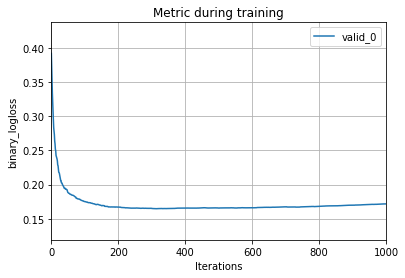

In [21]:
model_v4 = lgb.LGBMClassifier(n_estimators=1000, random_state=RANDOM_STATE, n_jobs=-1)
model_v4.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)
lgb.plot_metric(model_v4);

y_pred = model_v4.predict(X_test)
print('previous best score =', 0.9318277932842765)
print('model_v4 score =', f1_score(y_test, y_pred, average='micro'))

In [22]:
print(model_v4.best_iteration_)
print(model_v4.best_score_)

None
defaultdict(<class 'collections.OrderedDict'>, {'valid_0': OrderedDict([('binary_logloss', 0.17187529455268036)])})


previous best score = 0.9318277932842765
model_v4 score = 0.9448469866166567


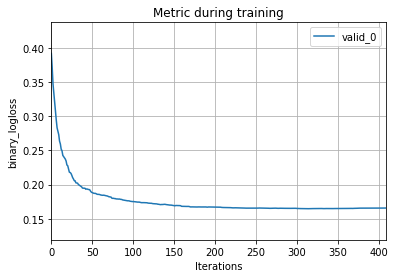

In [23]:
model_v4 = lgb.LGBMClassifier(n_estimators=650, random_state=RANDOM_STATE, n_jobs=-1)
model_v4.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False, early_stopping_rounds=100)
lgb.plot_metric(model_v4);

y_pred = model_v4.predict(X_test)
print('previous best score =', 0.9318277932842765)
print('model_v4 score =', f1_score(y_test, y_pred, average='micro'))

In [24]:
print(model_v4.best_iteration_)
print(model_v4.best_score_)

309
defaultdict(<class 'collections.OrderedDict'>, {'valid_0': OrderedDict([('binary_logloss', 0.16482338930650406)])})


previous best score = 0.9448469866166567
model_v5 score = 0.945869917313102


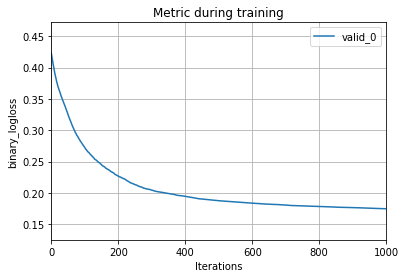

In [25]:
model_v5 = lgb.LGBMClassifier(n_estimators=1000, learning_rate=0.01, random_state=RANDOM_STATE, n_jobs=-1)
model_v5.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)
lgb.plot_metric(model_v5);

y_pred = model_v5.predict(X_test)
print('previous best score =', 0.9448469866166567)
print('model_v5 score =', f1_score(y_test, y_pred, average='micro'))

previous best score = 0.945869917313102
model_v5 score = 0.9463813826613247


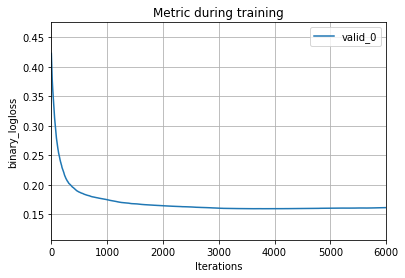

In [26]:
model_v5 = lgb.LGBMClassifier(n_estimators=6000, learning_rate=0.01, random_state=RANDOM_STATE, n_jobs=-1)
model_v5.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)
lgb.plot_metric(model_v5);

y_pred = model_v5.predict(X_test)
print('previous best score =', 0.945869917313102)
print('model_v5 score =', f1_score(y_test, y_pred, average='micro'))

In [27]:
print(model_v5.best_iteration_)
print(model_v5.best_score_)

None
defaultdict(<class 'collections.OrderedDict'>, {'valid_0': OrderedDict([('binary_logloss', 0.1610930823851455)])})


previous best score = 0.9463813826613247
model_v5 score = 0.9473190691330662
best_iteration_ 3860


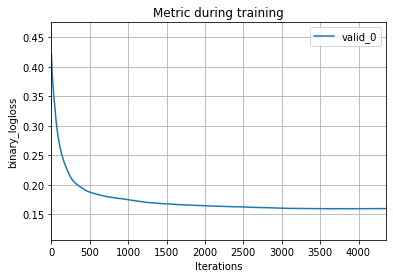

In [28]:
model_v5 = lgb.LGBMClassifier(n_estimators=6000, learning_rate=0.01, random_state=RANDOM_STATE, n_jobs=-1)
model_v5.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False, early_stopping_rounds=500)
lgb.plot_metric(model_v5);

y_pred = model_v5.predict(X_test)
print('previous best score =', 0.9463813826613247)
print('model_v5 score =', f1_score(y_test, y_pred, average='micro'))
print('best_iteration_', model_v5.best_iteration_)

previous best score = 0.9473190691330662
model_v6 score = 0.9457846730883983


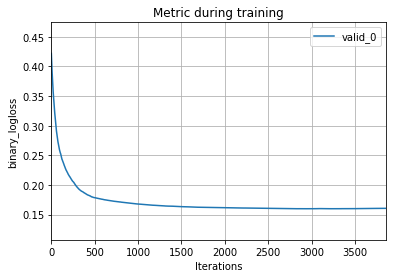

In [29]:
model_v6 = lgb.LGBMClassifier(n_estimators=3860, learning_rate=0.01, max_depth=14, num_leaves=50, 
                              random_state=RANDOM_STATE, n_jobs=-1)
model_v6.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)
lgb.plot_metric(model_v6);

y_pred = model_v6.predict(X_test)
print('previous best score =', 0.9473190691330662)
print('model_v6 score =', f1_score(y_test, y_pred, average='micro'))

model_v5 score = 0.9473190691330662
model score = 0.9473190691330662


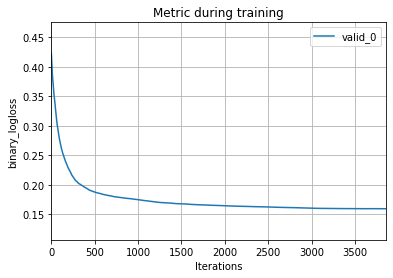

In [30]:
model = lgb.LGBMClassifier(n_estimators=3860, learning_rate=0.01, random_state=RANDOM_STATE, n_jobs=-1)
model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)
lgb.plot_metric(model);

print('model_v5 score =', f1_score(y_test, model_v5.predict(X_test), average='micro'))
print('model score =', f1_score(y_test, model.predict(X_test), average='micro'))

In [31]:
# save model
with open('model_hypothesis_2.pkl', 'wb') as f:
    pickle.dump(model, f)

# Итог

По итогу модель model_v5 с параметрами `n_estimators=3860, learning_rate=0.01` дала лучший результат из проверенных моделей,  
`f1_micro = 0.9473190691330662`